### Table of Experiments

#### exp1
- `nux = (2-10)`
- `gamma = [8-15]`
- `number of TRN Neurons = [500, 1000]`
-  No Additional supressional activity at 1000ms for 50ms

#### exp2
- `nux = (2-10)`
- `gamma = [8-15]`
- `number of TRN Neurons = [500, 1000]`
-  Additional supressional activity at 1000ms for 50ms

In [1]:
# To get the lastest pickle files run
! cat pullresults.sh

#!/bin/bash

rsync -auv hameed@login.inm.kfa-juelich.de:/users/hameed/simulenation/src/demyelination/data/ /home/hunaid/simulenation/src/demyelination/data/



In [1]:
import warnings
warnings.filterwarnings('ignore') # warnings are for the weak

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

In [3]:
sys.path.append("demyelination/") # we need this to successfully read pickle files

In [4]:
import fna

In [5]:
import pipeline as pipeline

In [52]:
def preparedf (dataobjs):
    # input dataframe
    # output organized data
    if len(dataobjs) == 0:
        raise Exception("No activity files found.")

    parts = dataobjs[0].spikeobj.keys()

    df = pd.DataFrame()

    for part in parts:
        for data in dataobjs:
            tmp = data.params
            tmp = tmp.update({
                "brainPart" : part,
                "meanSpkRate" : data.spikeobj[part].mean_rate(),
                "pearsonCoeff" : data.metrics['pearsoncoeff'][part],
                "cvIsi" : data.spikeobj[part].cv_isi().mean(),
                "meanBurstSpikePercentageCerina" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(1000, 2000), "cerina" )),
                "meanBurstSpikePercentageMIT" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part].time_slice(1000, 2000), "mit" )),
                "meanBurstSpikePercentage" : np.mean(computePopulationBurstSpikeRatio( data.spikeobj[part] ))
            })
            df = df.append(data.params, ignore_index=True)

    return df

In [127]:
def makesubplot (data, fig, ax, attr, title="", unit=""):
    for axis, part in zip([0, 1, 2, 3], ["MGN", "TRN", "eA1", "iA1"]):
        varone = "fullmodel_w_ctx_trn"
        vartwo = "w_mgn_ctx"
        d = data[ data["brainPart"] == part ].pivot_table(attr, varone, vartwo)

        p = ax[axis].imshow(d, interpolation="nearest")
        
        cb = fig.colorbar(p, ax=ax[axis])
        cb.set_label(unit)

        ax[axis].set_title(title + " " + attr + " " + part)

        j = 2
        
        ax[axis].set_yticks(range(0, len(d.index.values), j))
        ax[axis].set_yticklabels(d.index.values[::j])
        
        ax[axis].set_xticks(range(0, len(d.columns.values), j))
        ax[axis].set_xticklabels(d.columns.values[::j])
        
        ax[axis].set_ylabel(varone)
        ax[axis].set_xlabel(vartwo)


In [235]:
def makerasterplot (fls, path, fig, ax):
    for idx, fl in enumerate(fls):
        d = pd.read_pickle(path + fl)

        fig.set_size_inches(50, 9)
        #plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

        for axis, part in zip([0, 1, 2, 3], d.spikeobj.keys()):
            clr = 'red' if part == 'MGN' else 'blue'

            d.spikeobj[part].raster_plot(ax=ax[idx][axis], dt=10, display=False, color=clr, ms=1)
            ax[idx][axis].set_ylabel(part)
            ax[idx][axis].set_title(fl)

    fig.tight_layout()

In [9]:
def computeBurstSpikeRatio (spiketrain, criterion="cerina"):
    if criterion == "cerina":
        quiettime = 50.
        minspikes = 4.
    elif criterion == "mit":
        quiettime = 100.
        minspikes = 2.
    else:
        raise Exception("Criterion not implemented")
        
    spkdiff = np.diff(spiketrain)

    count = 0
    idx = 1

    while idx < len(spkdiff):
        # was the last spike less than 50ms ago
        if spkdiff[idx-1] <= 100.:
            idx += 1
            continue

        # how many more burst spikes can we find?
        c = 1
        
        # is the next spike within 4ms
        if spkdiff[idx] <= quiettime:
            # how many of the following spikes are within 8ms
            # we need at least 3 more for this to be a burst
            
            try:
                while spkdiff[idx+c] <= 20.:
                    c += 1

                if c >= minspikes:
                    count += c + 1
                    idx += c
                    continue # restart the loop
            except:
                pass
        
        idx += 1

    return 0 if len(spiketrain) == 0 else 100 * count / len(spiketrain)

def computePopulationBurstSpikeRatio (population, criterion="cerina"):
    k = population.spiketrains.keys()
    
    return [computeBurstSpikeRatio(population.spiketrains[_].spike_times, criterion) for _ in k]

#computeBurstSpikeRatio(spk.spikeobj['MGN'].spiketrains[500.0].spike_times)
#computePopulationBurstSpikeRatio(spk.spikeobj['MGN'])

## Without Stim

In [222]:
files2 = pipeline.readfiles("demyelination/data/fullmodel/activity/");
df = preparedf(files2);

In [217]:
df.w_ctx_mgn.unique()

array([0.01, 0.05])

In [219]:
df

,fullmodel_w_ctx_trn,w_ctx_mgn,w_mgn_ctx,brainPart,meanSpkRate,pearsonCoeff,cvIsi,meanBurstSpikePercentageCerina,meanBurstSpikePercentageMIT,meanBurstSpikePercentage
0,0.05,0.01,0.05,MGN,9.448247,-0.000133,NaN,3.304677,11.866662,6.629125
1,0.01,0.05,0.01,MGN,10.499530,-0.002472,NaN,3.276006,12.009276,6.478168
2,0.05,0.05,0.05,MGN,9.547492,0.004949,NaN,3.062541,12.349085,6.301202
3,0.01,0.05,0.05,MGN,10.151489,0.003912,NaN,3.279001,11.792978,6.496876
4,0.01,0.01,0.05,MGN,9.970380,0.001519,NaN,3.530284,12.915399,6.583500
5,0.01,0.01,0.01,MGN,9.550268,0.003246,NaN,3.434555,11.798700,6.152504
6,0.05,0.05,0.01,MGN,9.114633,0.003370,NaN,3.136959,11.687470,5.945163
7,0.05,0.01,0.01,MGN,9.360791,0.005974,NaN,2.968063,11.279815,6.001345
8,0.05,0.01,0.05,TRN,14.713011,0.000230,0.794296,0.090125,11.045868,0.285154
9,0.01,0.05,0.01,TRN,14.156353,0.002607,0.793089,0.203247,11.177053,0.320233


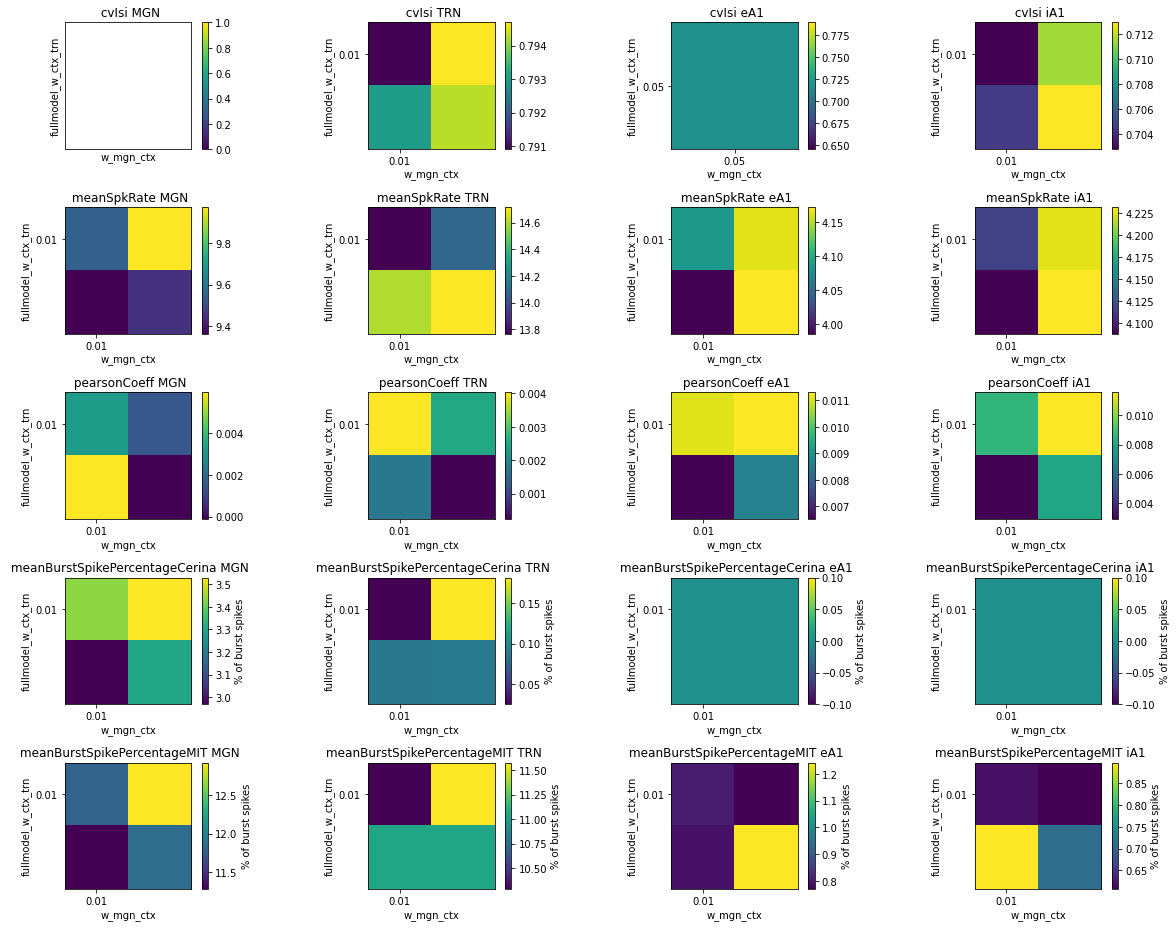

In [218]:
fig, ax = plt.subplots(nrows=5, ncols=4)

fig.set_size_inches(17, 13)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

w = .01

makesubplot(df[df.w_ctx_mgn==w], fig, ax[0], "cvIsi")

makesubplot(df[df.w_ctx_mgn==w], fig, ax[1], "meanSpkRate")

makesubplot(df[df.w_ctx_mgn==w], fig, ax[2], "pearsonCoeff")

makesubplot(df[df.w_ctx_mgn==w], fig, ax[3], "meanBurstSpikePercentageCerina", unit="% of burst spikes")

makesubplot(df[df.w_ctx_mgn==w], fig, ax[4], "meanBurstSpikePercentageMIT", unit="% of burst spikes")

fig.tight_layout()

plt.savefig("/home/pbr-student/Downloads/thesis-plots/fullmodel-nothalctxconn.pdf")

In [164]:
df[df.w_mgn_ctx==0.001][df.w_ctx_mgn==0.001]

,fullmodel_w_ctx_trn,w_ctx_mgn,w_mgn_ctx,brainPart,meanSpkRate,pearsonCoeff,cvIsi,meanBurstSpikePercentageCerina,meanBurstSpikePercentageMIT,meanBurstSpikePercentage
19,0.001,0.001,0.001,MGN,10.260762,-0.000139,NaN,3.139070,12.200799,6.829359
88,0.001,0.001,0.001,TRN,13.937506,-0.000312,0.794541,0.135761,11.405030,0.263686
157,0.001,0.001,0.001,eA1,4.029033,0.014585,0.710769,0.000000,0.768393,0.000000
226,0.001,0.001,0.001,iA1,4.078802,0.003732,0.694889,0.000000,0.747381,0.000000


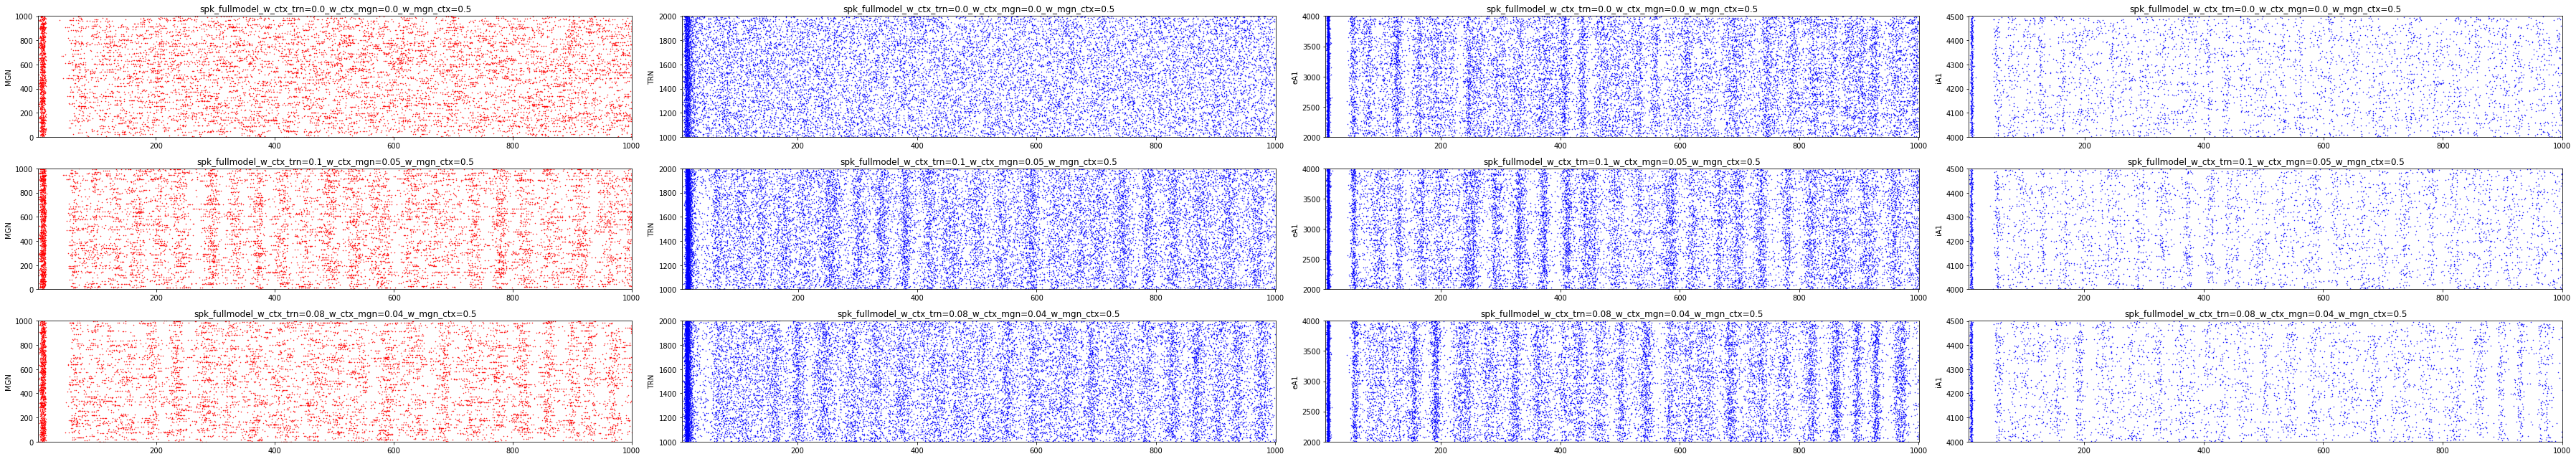

In [254]:
fls = [
    "spk_fullmodel_w_ctx_trn=0.0_w_ctx_mgn=0.0_w_mgn_ctx=0.5",
    "spk_fullmodel_w_ctx_trn=0.1_w_ctx_mgn=0.05_w_mgn_ctx=0.5",
    "spk_fullmodel_w_ctx_trn=0.08_w_ctx_mgn=0.04_w_mgn_ctx=0.5",
]
fig, ax = plt.subplots(nrows=len(fls), ncols=4)
pth = "demyelination/data/fullmodel/activity/"

makerasterplot(fls, pth, fig, ax)

In [240]:
spk = pd.read_pickle(pth + fls[0])
spk.spikeobj['eA1'].mean_rate(), spk.spikeobj['iA1'].mean_rate()

(8.21410579345088, 8.544080604534003)

In [251]:
spk = pd.read_pickle(pth + fls[1])
spk.spikeobj['eA1'].mean_rate(), spk.spikeobj['iA1'].mean_rate(), \
spk.spikeobj['MGN'].mean_rate(), spk.spikeobj['TRN'].mean_rate()

(8.28564231738035, 8.42222029280262, 9.626805896383146, 19.5180596875791)

In [261]:
spk = pd.read_pickle(pth + fls[2])
spk.spikeobj['eA1'].mean_rate(), spk.spikeobj['iA1'].mean_rate(), \
spk.spikeobj['MGN'].mean_rate(), spk.spikeobj['TRN'].mean_rate()

(8.245569773807965, 8.36491935483871, 8.888888780077272, 17.058113186520448)

In [257]:
spk.metrics

In [260]:
spk.spikeobj['eA1'].pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=2)

(0.03145997032813061, 0.07620447331958731)

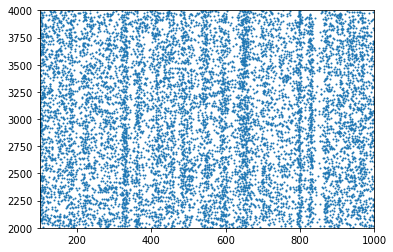

In [234]:
spk.spikeobj['eA1'].time_slice(100, 1000).raster_plot(dt=10, ms=2)

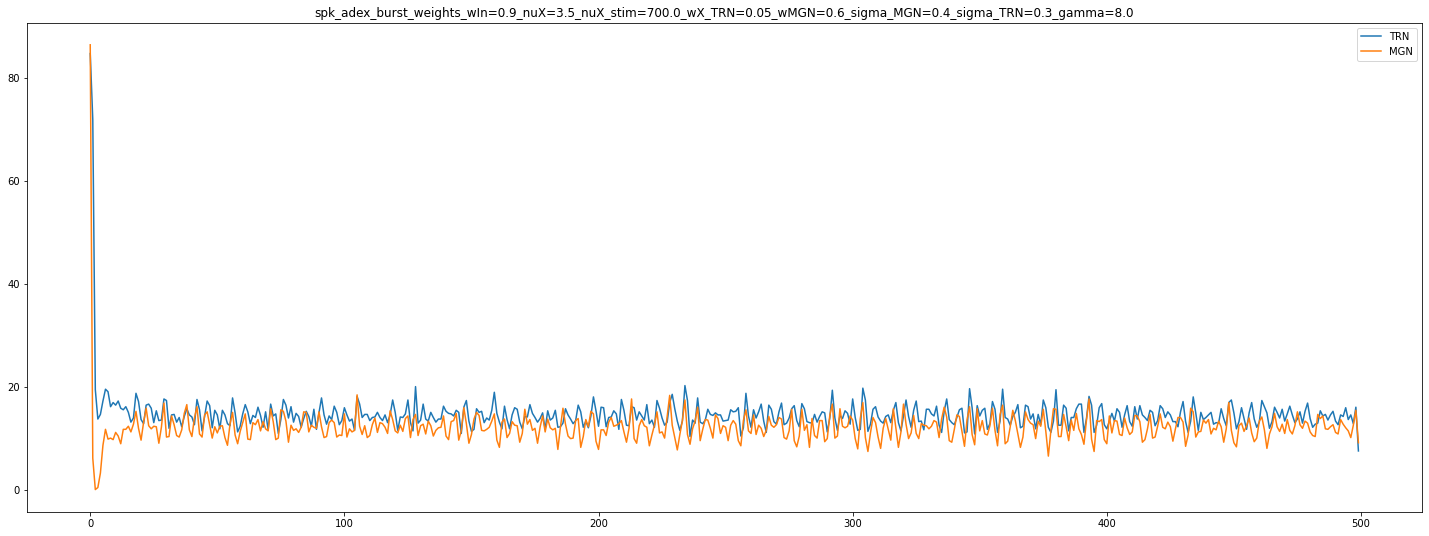

In [108]:
fl = 'spk_adex_burst_weights_wIn=0.9_nuX=3.5_nuX_stim=700.0_wX_TRN=0.05_wMGN=0.6_sigma_MGN=0.4_sigma_TRN=0.3_gamma=8.0'
p = pd.read_pickle("demyelination/data/adex_burst_weights_wIn=0.9/activity/" + fl)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(25, 9)

ax.plot(p.spikeobj['TRN'].firing_rate(10, average=True), label='TRN')
ax.plot(p.spikeobj['MGN'].firing_rate(10, average=True), label='MGN')

plt.title(fl)

ax.legend()


In [81]:
#! ls demyelination/data/exp3/activity/
#| grep -E nuX=15

## With Stim

In [340]:
files2 = pipeline.readfiles("demyelination/data/adex_burst_weights_wIn=0.9_stimulated/activity/");
df2 = preparedf(files2);

In [284]:
fig, ax = plt.subplots(nrows=4, ncols=2)

fig.set_size_inches(13, 9)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

x = 0.4

makesubplot(df3[df3.sigma_MGN == x], fig, ax[0], "cvIsi")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[1], "meanSpkRate")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[2], "pearsonCoeff")

makesubplot(df3[df3.sigma_MGN == x], fig, ax[3], "meanBurstSpikeCount")

fig.tight_layout()

plt.show()

## Holisitic View

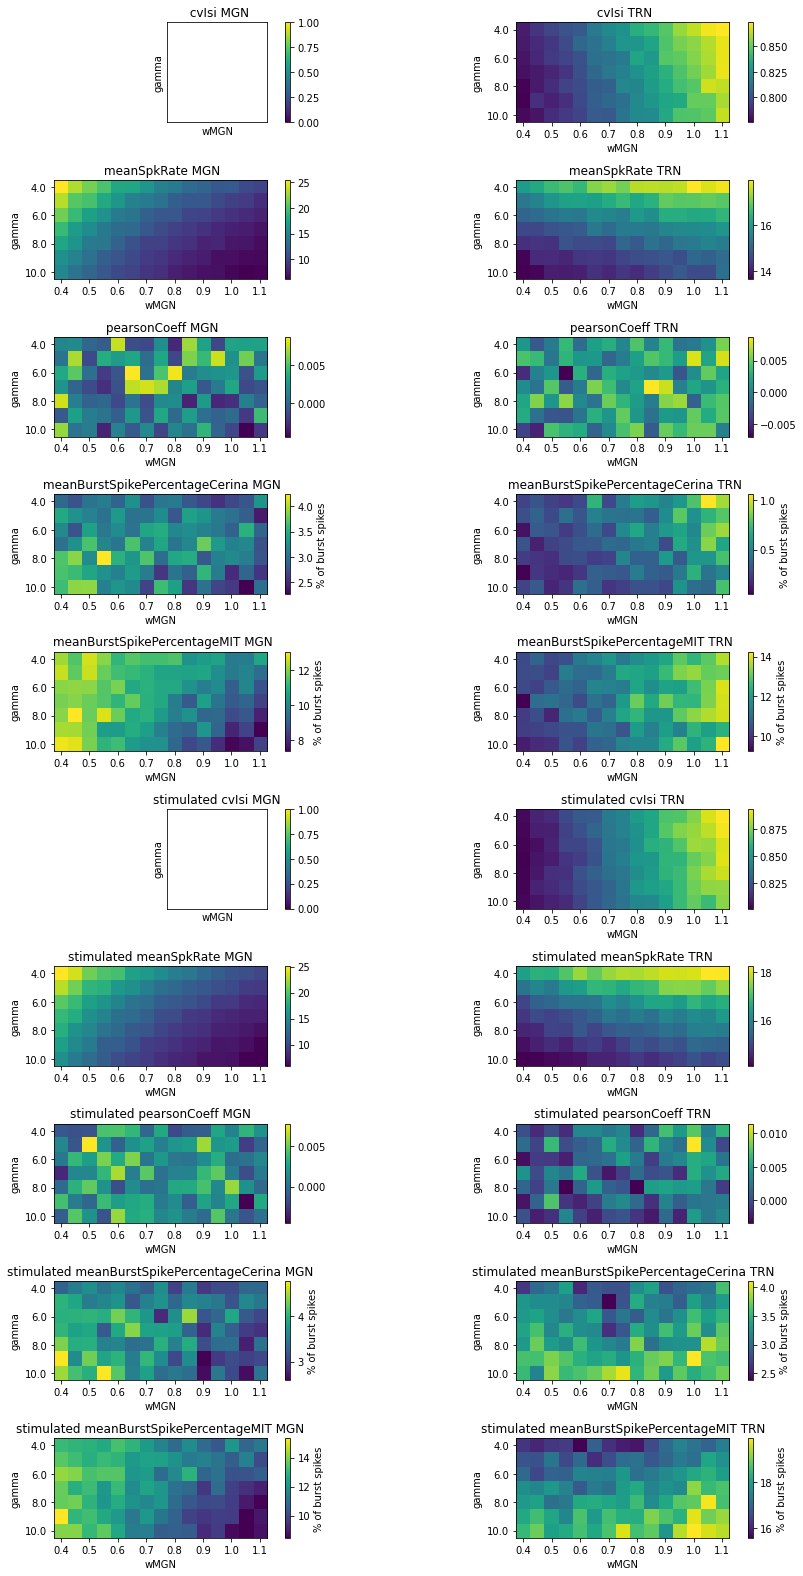

In [341]:
fig, ax = plt.subplots(nrows=10, ncols=2)

fig.set_size_inches(13, 22)
plt.subplots_adjust(left=0.01, right=0.03, top=0.03, bottom=0.02)

x = 0.4

makesubplot(df[df.sigma_MGN == x], fig, ax[0], "cvIsi")

makesubplot(df[df.sigma_MGN == x], fig, ax[1], "meanSpkRate")

makesubplot(df[df.sigma_MGN == x], fig, ax[2], "pearsonCoeff")

makesubplot(df[df.sigma_MGN == x], fig, ax[3], "meanBurstSpikePercentageCerina", unit="% of burst spikes")

makesubplot(df[df.sigma_MGN == x], fig, ax[4], "meanBurstSpikePercentageMIT", unit="% of burst spikes")

# now plotting exp with stimulation
makesubplot(df2[df2.sigma_MGN == x], fig, ax[5], "cvIsi", "stimulated")

makesubplot(df2[df2.sigma_MGN == x], fig, ax[6], "meanSpkRate", "stimulated")

makesubplot(df2[df2.sigma_MGN == x], fig, ax[7], "pearsonCoeff", "stimulated")

makesubplot(df2[df2.sigma_MGN == x], fig, ax[8], "meanBurstSpikePercentageCerina", "stimulated", unit="% of burst spikes")

makesubplot(df2[df2.sigma_MGN == x], fig, ax[9], "meanBurstSpikePercentageMIT", "stimulated", unit="% of burst spikes")

fig.tight_layout()

#fig.suptitle("sigmaMGN=0.4, ", fontsize=16)
#ax[0][0].text(10, 10, "piece of text")

plt.savefig("/home/pbr-student/Downloads/thesis-plots/mit-sigmaMgn4.pdf")